In [1]:
import os
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [5]:
# Fungsi untuk memuat gambar dari folder tetap sama
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = image.load_img(img_path, target_size=(128, 128))
                img = image.img_to_array(img)
                img = img / 255.0
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Memuat data
base_dir = 'C:\\Users\\ASUS\\tugas_akhir_18\\databaru'
X_train, y_train = load_images_from_folder(os.path.join(base_dir, 'Training'))
X_val, y_val = load_images_from_folder(os.path.join(base_dir, 'Validation'))
X_test, y_test = load_images_from_folder(os.path.join(base_dir, 'Testing'))

# Mengonversi label menjadi kategori
label_to_index = {label: index for index, label in enumerate(np.unique(y_train))}
index_to_label = {index: label for label, index in label_to_index.items()}

y_train = to_categorical([label_to_index[label] for label in y_train], num_classes=len(label_to_index))
y_val = to_categorical([label_to_index[label] for label in y_val], num_classes=len(label_to_index))
y_test = to_categorical([label_to_index[label] for label in y_test], num_classes=len(label_to_index))

print(f'Set pelatihan: {X_train.shape[0]}')
print(f'Set validasi: {X_val.shape[0]}')
print(f'Set pengujian: {X_test.shape[0]}')


Set pelatihan: 1280
Set validasi: 160
Set pengujian: 160


In [50]:
# Definisi Model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_to_index), activation='softmax')
])

# Menentukan learning rate
learning_rate = 0.001

# Mengompilasi model dengan learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 30, 30, 64)       

In [51]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [52]:
# 4. Fungsi untuk Prediksi Gambar
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_label = index_to_label[np.argmax(prediction)]
    return predicted_label, confidence



In [56]:
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
40/40 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9469

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 23s 577ms/step - loss: 0.1658 - accuracy: 0.9469 - val_loss: 0.1613 - val_accuracy: 0.9250
Epoch 2/25
40/40 [==============================] - 23s 565ms/step - loss: 0.1450 - accuracy: 0.9523 - val_loss: 0.1968 - val_accuracy: 0.9375
Epoch 3/25
40/40 [==============================] - 23s 562ms/step - loss: 0.1387 - accuracy: 0.9484 - val_loss: 0.5314 - val_accuracy: 0.7688
Epoch 4/25
40/40 [==============================] - 26s 637ms/step - loss: 0.1772 - accuracy: 0.9414 - val_loss: 0.1738 - val_accuracy: 0.9438
Epoch 5/25
40/40 [==============================] - 23s 577ms/step - loss: 0.1288 - accuracy: 0.9461 - val_loss: 0.2187 - val_accuracy: 0.9000
Epoch 6/25
40/40 [==============================] - 24s 600ms/step - loss: 0.1041 - accuracy: 0.9672 - val_loss: 0.1430 - val_accuracy: 0.9563
Epoch 7/25
40/40 [==============================] - 24s 588ms/step - loss: 0.1834 - accuracy: 0.9367 - val_loss: 0.1351 - val_accuracy: 0.9312
Epoch 8/25

5/5 [==============================] - 1s 102ms/step - loss: 0.0370 - accuracy: 0.9937
Test Accuracy: 0.99


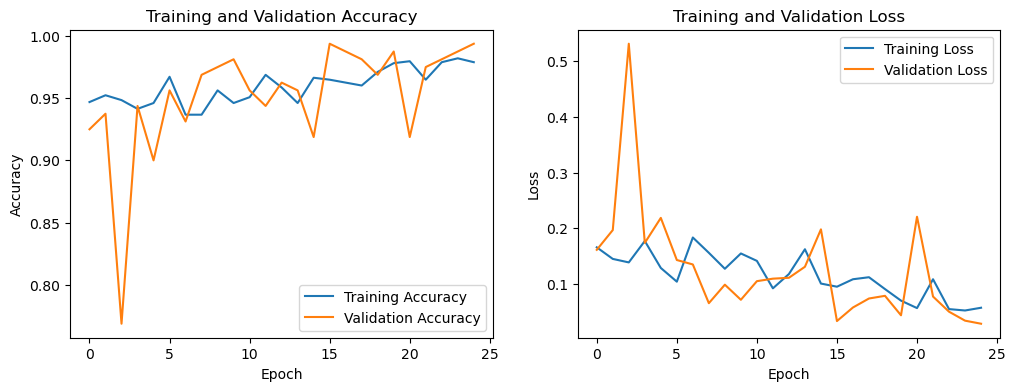

In [57]:
# Evaluasi model dengan data pengujian
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.2f}')

# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

5/5 [==============================] - 1s 115ms/step


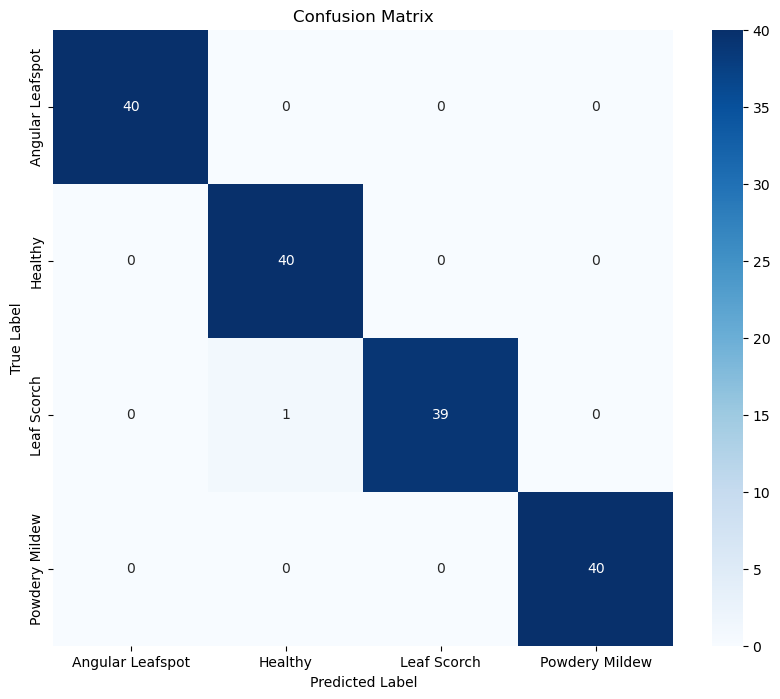

In [58]:
# Prediksi untuk Confusion Matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Mengambil label asli dari y_test dalam format integer
y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=index_to_label.values(), yticklabels=index_to_label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [59]:
model.save('32_0,001_.h5')


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FileUpload, Output, VBox
import io

# Load the trained model
model = load_model('32_0,001_.h5')  # Ganti dengan path model Anda

# Mapping label ke indeks dan sebaliknya
label_to_index = {
    'Angular Leafspot': 0,
    'Healthy': 1,
    'Leaf Scorch': 2,
    'Powdery Mildew': 3
}
index_to_label = {v: k for k, v in label_to_index.items()}

# Function to preprocess and predict the class of the uploaded image
def predict_image(change):
    img = change['new'][0]
    img = image.load_img(io.BytesIO(img['content']), target_size=(128, 128))  # Sesuaikan dengan target_size model Anda
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Check if the dimensions of the uploaded image match the dimensions used in the model
    if img_array.shape == (1, 128, 128, 3):  # Sesuaikan dengan dimensi yang diharapkan oleh model Anda
        predictions = model.predict(img_array)
        
        # Get class label and confidence
        predicted_label = index_to_label[np.argmax(predictions[0])]
        confidence = np.max(predictions[0]) * 100
        
        # Display the prediction result
        output.clear_output()
        with output:
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Predicted Label: {predicted_label}\nConfidence: {confidence:.2f}%')
            plt.show()
    else:
        output.clear_output()
        with output:
            print("Uploaded image does not match the required dimensions.")

# Create the file upload widget
file_upload = FileUpload(accept='image/*')

# Create the output widget
output = Output()

# Call the predict_image function when an image is uploaded
file_upload.observe(predict_image, names='value')

# Display the widgets
VBox([file_upload, output])


1/1 [==============================] - 0s 72ms/step


In [2]:
import tensorflow as tf

# Muat model Keras
model = tf.keras.models.load_model('32_0,001_.h5')

# Konversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('model_final.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpoabeenot\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpoabeenot\assets
